In [54]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [55]:
# this block is used for copying/moving files
import os
import shutil
import time
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/dataviz/bin/python'

In [56]:
# This is a custom python module with dictionaries of states and countries; 
# it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

In [57]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
import importlib
#importlib.reload(scd)

In [58]:
import numpy as np
import pandas as pd

In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [60]:
# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-12-24'

In [62]:
print ('If using Binder enter a timezone difference from UTC')
timezone = input(' Enter a number between 12 and -12:')
print(timezone)
if timezone:
    timezone = int(timezone)
    v = scd.tz_dict[timezone]
    t = pd.Timestamp.today(v)
    print (t)
    day = t.date().strftime('%Y-%m-%d')
day

If using Binder enter a timezone difference from UTC


 Enter a number between 12 and -12: 


'2021-12-24'

### Moves all files from covid_data_update to covid_data 

In [63]:
# Ensure helper files used in past have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx
!rm -f covid_text flist_of_covid_png temp.xlsx

In [64]:
!mkdir covid_data_update

mkdir: covid_data_update: File exists


In [65]:
# House keeping covid_data_update folder
# preparing the move of all files from covid_data_update to covid_data 
# so that we are left with an empty covid_date_update folder
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 
file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
['outbreaks-TYPE-2021-12-24.csv', 'outbreaks-per-month-2021-12-24.png', 'outbreaks-TOTAL-2021-12-24.csv', 'outbreaks-COUNTY-2021-12-24.csv', 'outbreaks-piechart-2021-12-24.png', 'outbreaks-DATE-2021-12-24.csv', 'boulder-2021-12-24.csv', 'this_month_outbreaks-piechart-2021-12-24.png']


In [12]:
# The below cell will move and archive all files in covid_data_update to covid_data

In [13]:
%%capture
# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [66]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').replace('null','0').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [67]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: co nm ri


{'colorado': 'CO', 'new-mexico': 'NM', 'rhode-island': 'RI'}

### State Scraping section

In [68]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end time to yesterday

#day == pd.Timestamp.today().strftime('%Y-%m-%d')
end = pd.Timestamp.today() - pd.Timedelta(days=1)
print(f'end changed to yesterday: {end}')
#else:
#   end = pd.Timestamp.today()
#    print(f'end changed to {end}')
    
# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.sort_index(ascending = False).head()
state.shape

end changed to yesterday: 2021-12-23 15:47:32.962540


651

677

,CO,NM,RI
2021-12-23,NaN,NaN,NaN
2021-12-22,NaN,NaN,NaN
2021-12-21,NaN,NaN,NaN
2021-12-20,NaN,NaN,NaN
2021-12-19,NaN,NaN,NaN


(651, 3)

In [69]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
    len(state_previous_cases)
    
    # ensure match between length of the empty df and the new list
    if len(st_index)!= len(state_previous_cases):
        print (len(st_index))
        print (len(state_previous_cases))
        state_previous_cases = state_previous_cases[:-1]
        print (len(state_previous_cases))
    
    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
state.sort_index(ascending = False).head()   

651

651

651

,CO,NM,RI
2021-12-23,3611,1140,1687
2021-12-22,3723,905,1811
2021-12-21,3351,710,1015
2021-12-20,1174,1035,650
2021-12-19,1038,1035,611


In [70]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['CO', 'NM', 'RI']



Choose state for rolling averge: 


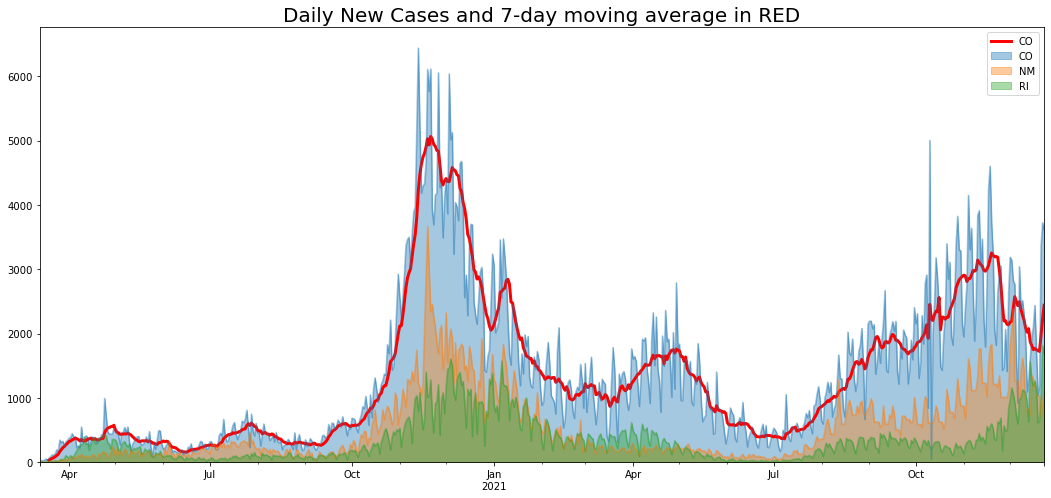

In [71]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

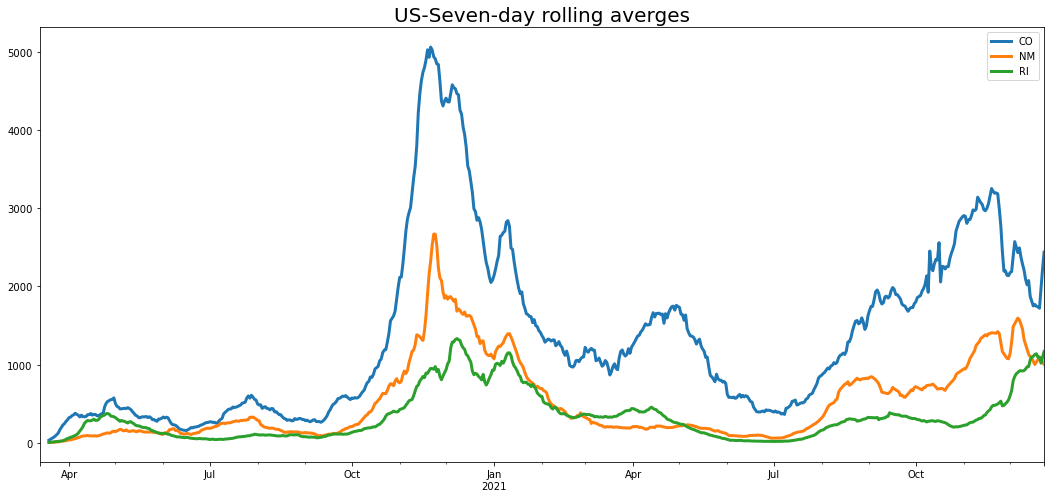

In [72]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

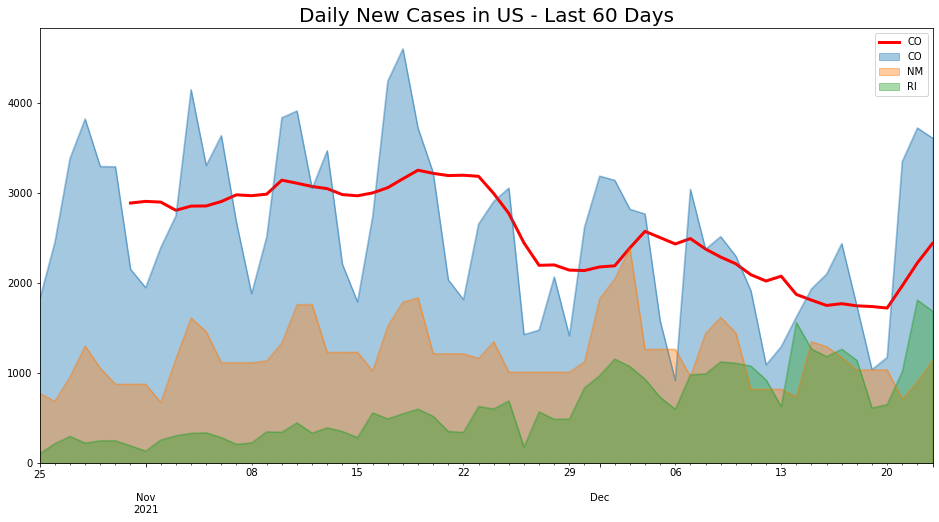

In [73]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

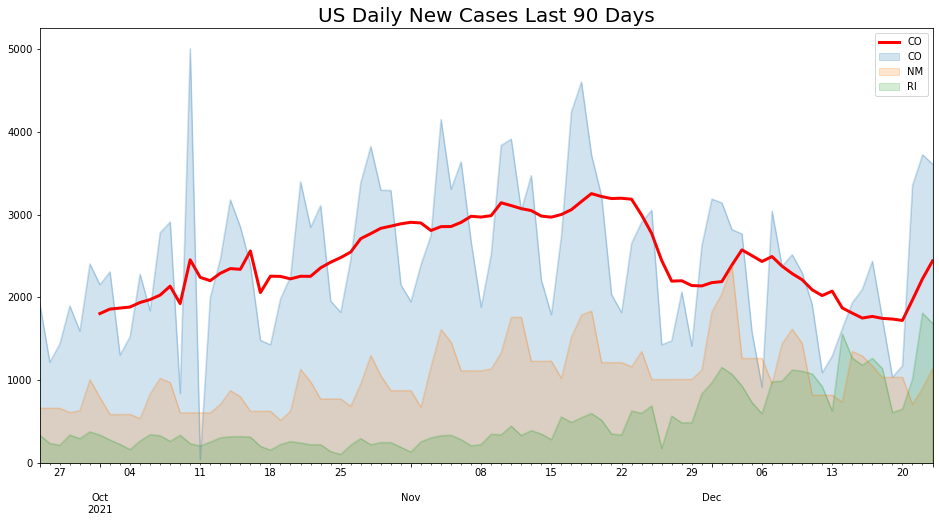

In [74]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [75]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,CO,NM,RI
2021-12-23,3611,1140,1687
2021-12-22,3723,905,1811
2021-12-21,3351,710,1015
2021-12-20,1174,1035,650
2021-12-19,1038,1035,611
2021-12-18,1744,1034,1141
2021-12-17,2438,1173,1265
2021-12-16,2099,1293,1183
2021-12-15,1936,1349,1267
2021-12-14,1622,737,1561


### Custom country dictionaries

In [76]:

# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: uk de


{'germany': 'DE', 'uk': 'UK'}



### Scraping section

In [77]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.sort_index(ascending = False).head()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.sort_index(ascending = False).head()

['DE', 'UK']

,DE,UK
2021-12-23,NaN,NaN
2021-12-22,NaN,NaN
2021-12-21,NaN,NaN
2021-12-20,NaN,NaN
2021-12-19,NaN,NaN


https://www.worldometers.info/coronavirus/country/germany


677

https://www.worldometers.info/coronavirus/country/uk


677

,DE,UK
2021-12-23,39196,119517
2021-12-22,45858,108509
2021-12-21,35049,90094
2021-12-20,21710,90943
2021-12-19,24190,82083


Countries available: ['DE', 'UK']



Choose country for rolling averge: 


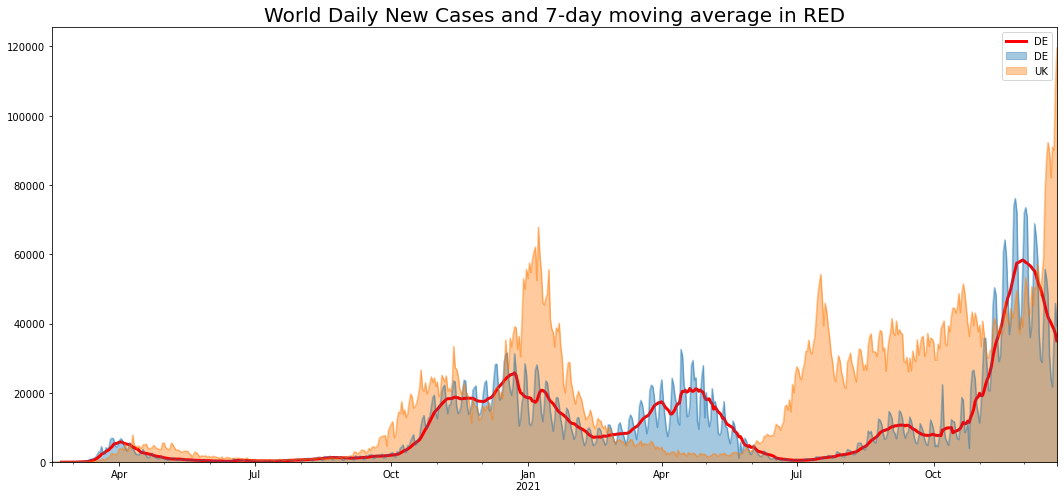

In [78]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

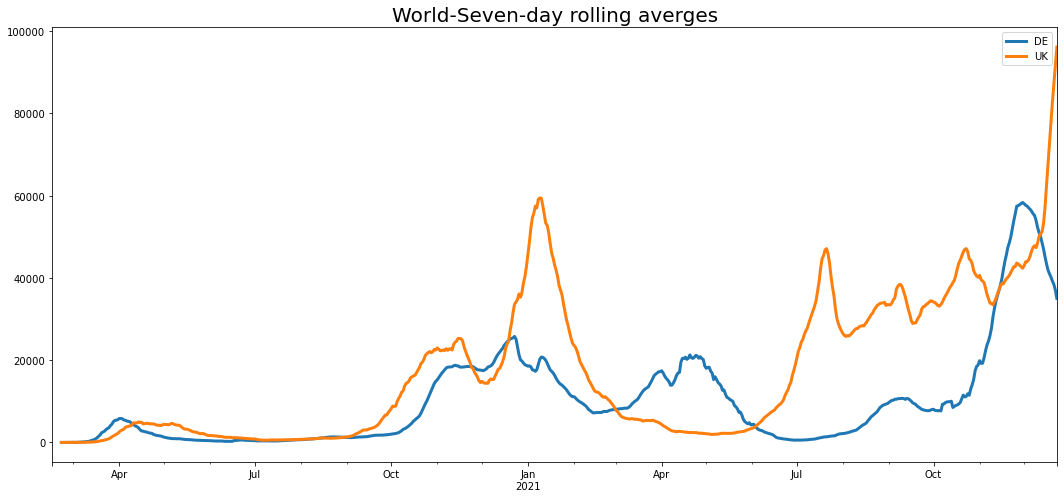

In [79]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

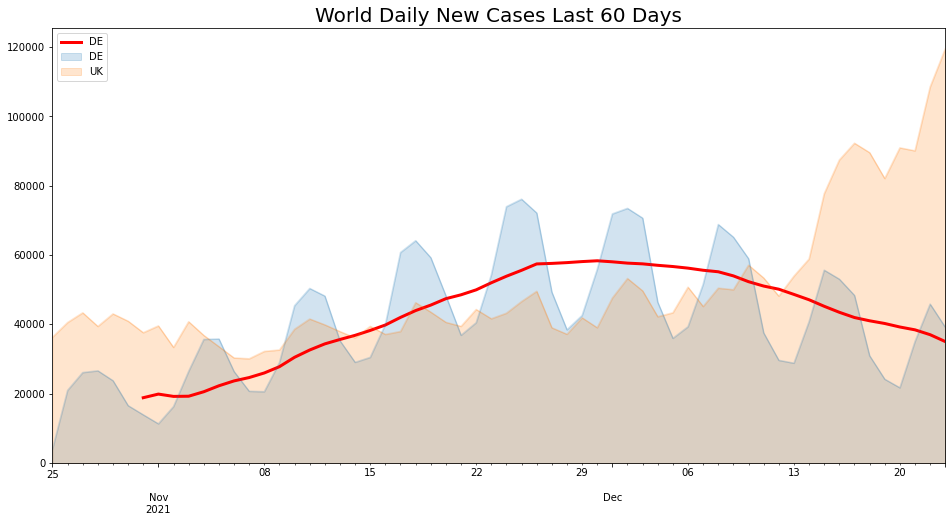

In [80]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


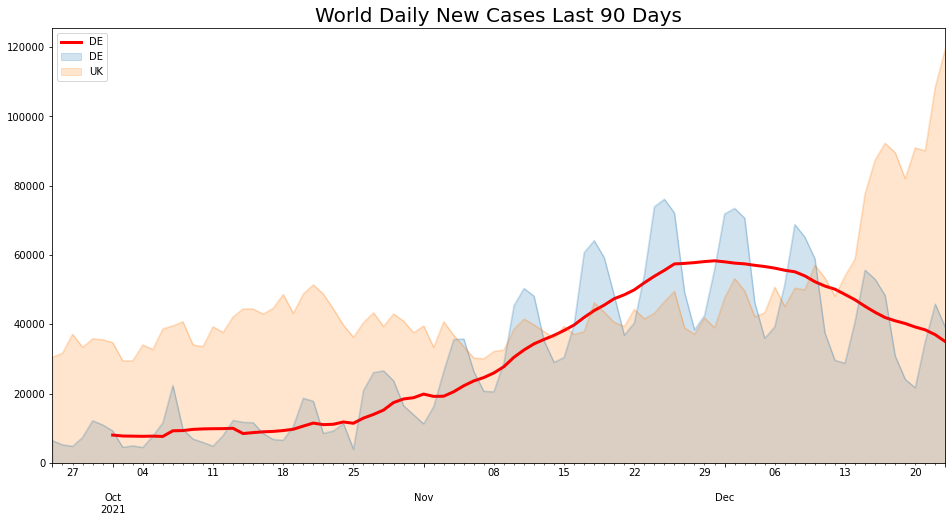

In [81]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [82]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
country.sort_index(ascending = False)

,DE,UK
2021-12-23,39196,119517
2021-12-22,45858,108509
2021-12-21,35049,90094
2021-12-20,21710,90943
2021-12-19,24190,82083
2021-12-18,30953,89571
2021-12-17,48375,92285
2021-12-16,53057,87438
2021-12-15,55650,77710
2021-12-14,40795,58870


### Save merged dataframes to csv

In [83]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [84]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)

# Save to csv by uncommenting out the next line
# world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,CO,NM,RI,DE,UK
2021-12-23,3611,1140,1687,39196,119517
2021-12-22,3723,905,1811,45858,108509
2021-12-21,3351,710,1015,35049,90094
2021-12-20,1174,1035,650,21710,90943
2021-12-19,1038,1035,611,24190,82083


In [85]:
# Note that the last week may be only a partial unless this is executed at end of week
# End of week is Sunday, so this should be executed on Mondays
df = world.resample('w').sum()
df.sort_index(ascending = False).head(10)

,CO,NM,RI,DE,UK
2021-12-26,11859,3790,5163,141813,409063
2021-12-19,12171,7441,7656,281824,541880
2021-12-12,14154,8371,6802,351073,355016
2021-12-05,17531,10918,6184,396878,317050
2021-11-28,15407,7764,3490,404769,301501
2021-11-21,22356,9829,3348,339756,284344
2021-11-14,20876,9565,2435,257867,258905
2021-11-07,20858,8012,1850,172611,244490
2021-10-31,20220,6521,1524,131880,281168
2021-10-24,16973,5433,1466,82857,325056


In [86]:
!ls covid_data_update

boulder-2021-12-24.csv
outbreaks-COUNTY-2021-12-24.csv
outbreaks-DATE-2021-12-24.csv
outbreaks-TOTAL-2021-12-24.csv
outbreaks-TYPE-2021-12-24.csv
outbreaks-per-month-2021-12-24.png
outbreaks-piechart-2021-12-24.png
this_month_outbreaks-piechart-2021-12-24.png
us_2021-12-24.png
us_CO_NM_RI_last_60_days_2021-12-24.png
us_CO_NM_RI_last_90_days_2021-12-24.png
us_rolling_avg_2021-12-24.png
world_2021-12-24.png
world_DE_UK_last_60_days_2021-12-24.png
world_DE_UK_last_90_days_2021-12-24.png
world_rolling_avg_2021-12-24.png


### Displays all updated graphs files

['covid_data_update/outbreaks-per-month-2021-12-24.png',
 'covid_data_update/outbreaks-piechart-2021-12-24.png',
 'covid_data_update/this_month_outbreaks-piechart-2021-12-24.png',
 'covid_data_update/us_2021-12-24.png',
 'covid_data_update/us_CO_NM_RI_last_60_days_2021-12-24.png',
 'covid_data_update/us_CO_NM_RI_last_90_days_2021-12-24.png',
 'covid_data_update/us_rolling_avg_2021-12-24.png',
 'covid_data_update/world_2021-12-24.png',
 'covid_data_update/world_DE_UK_last_60_days_2021-12-24.png',
 'covid_data_update/world_DE_UK_last_90_days_2021-12-24.png',
 'covid_data_update/world_rolling_avg_2021-12-24.png']

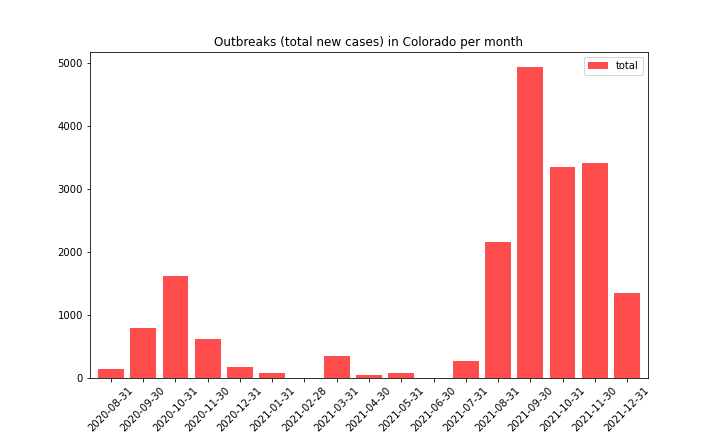

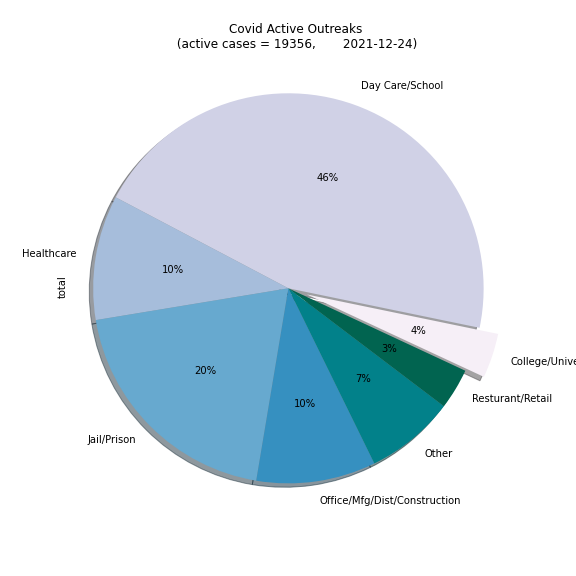

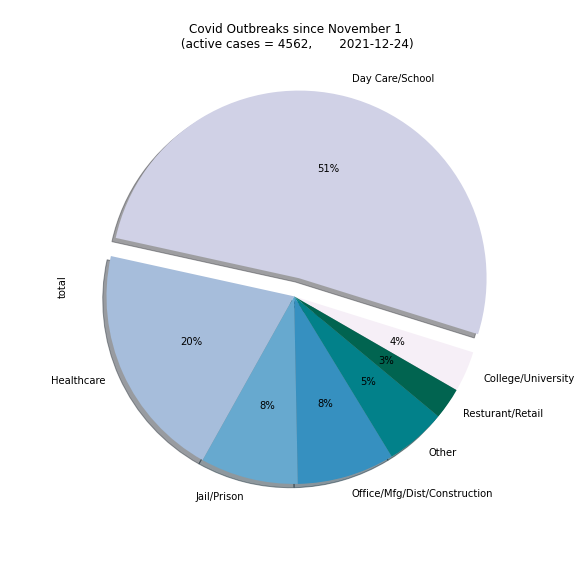

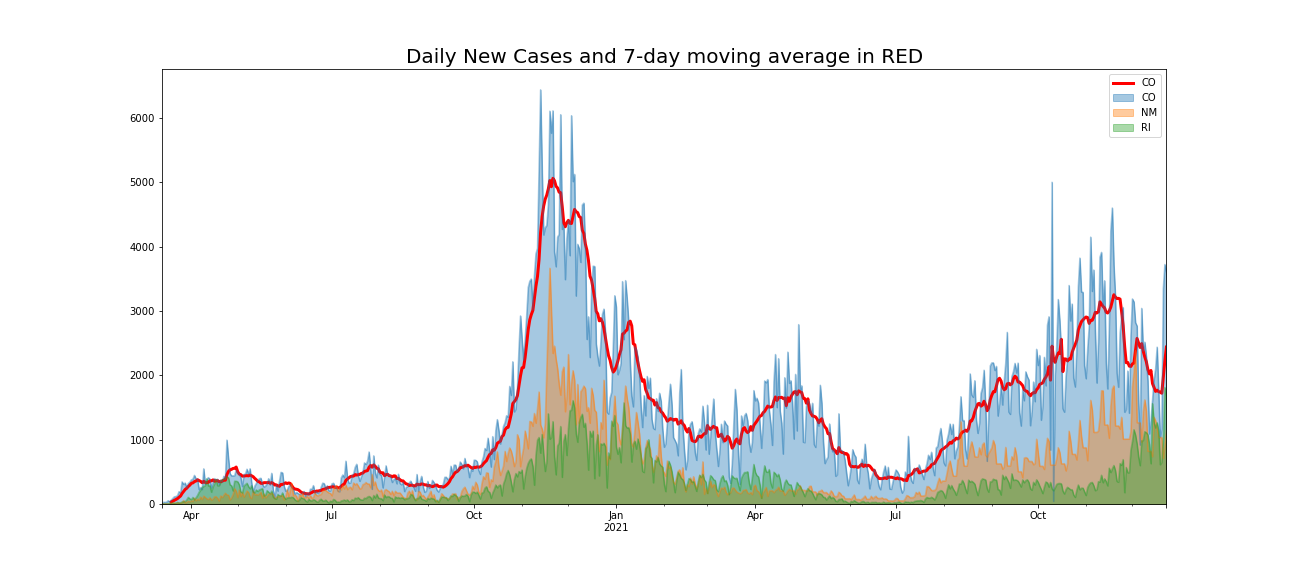

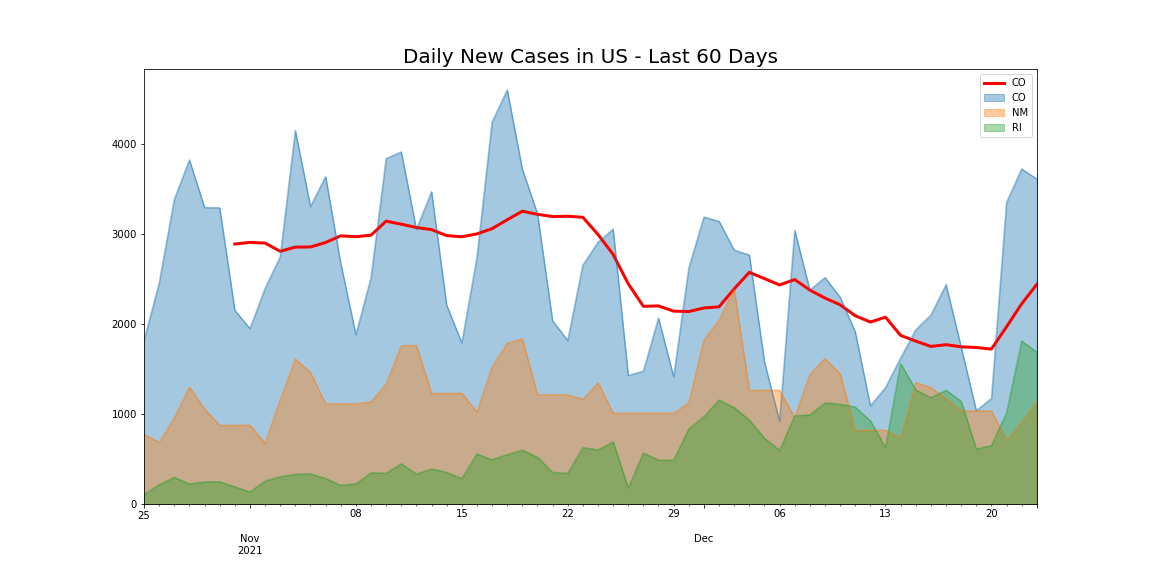

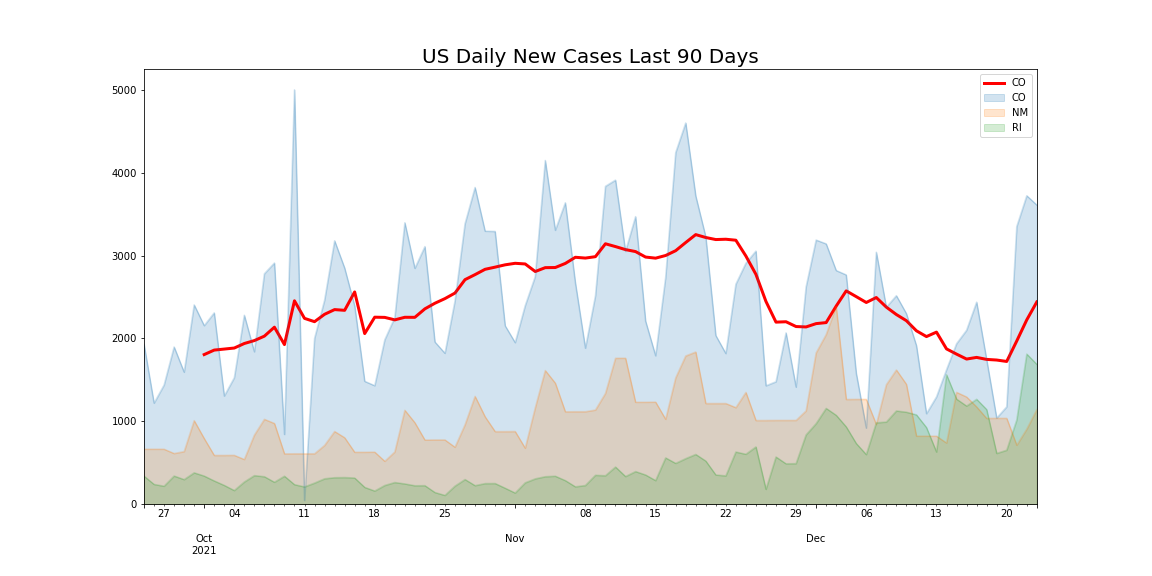

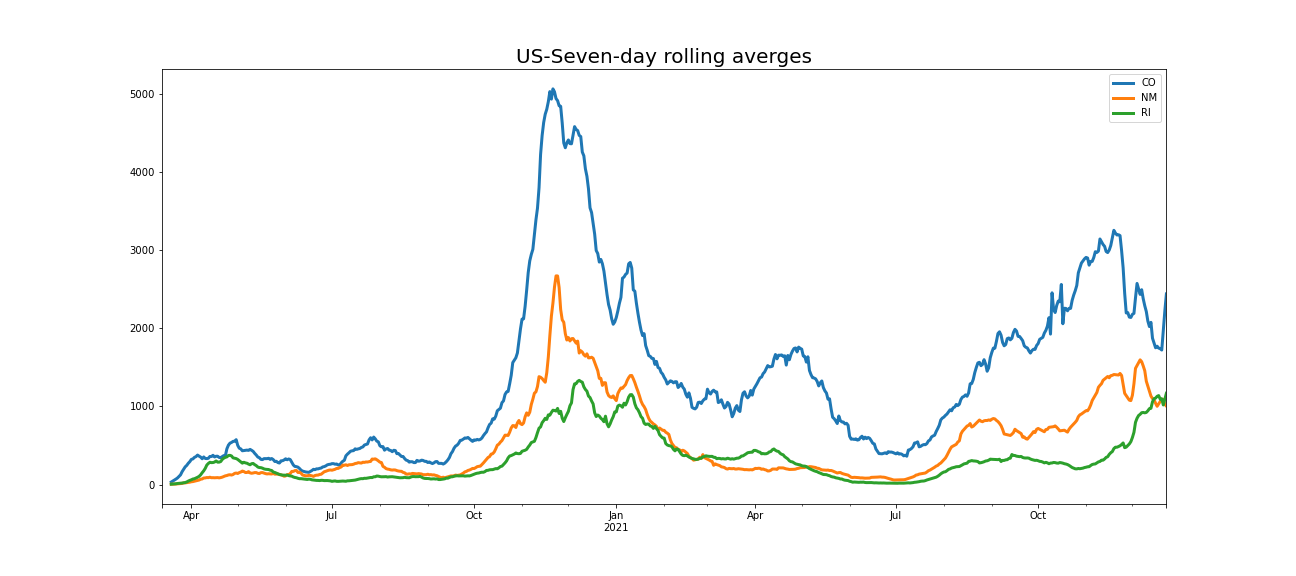

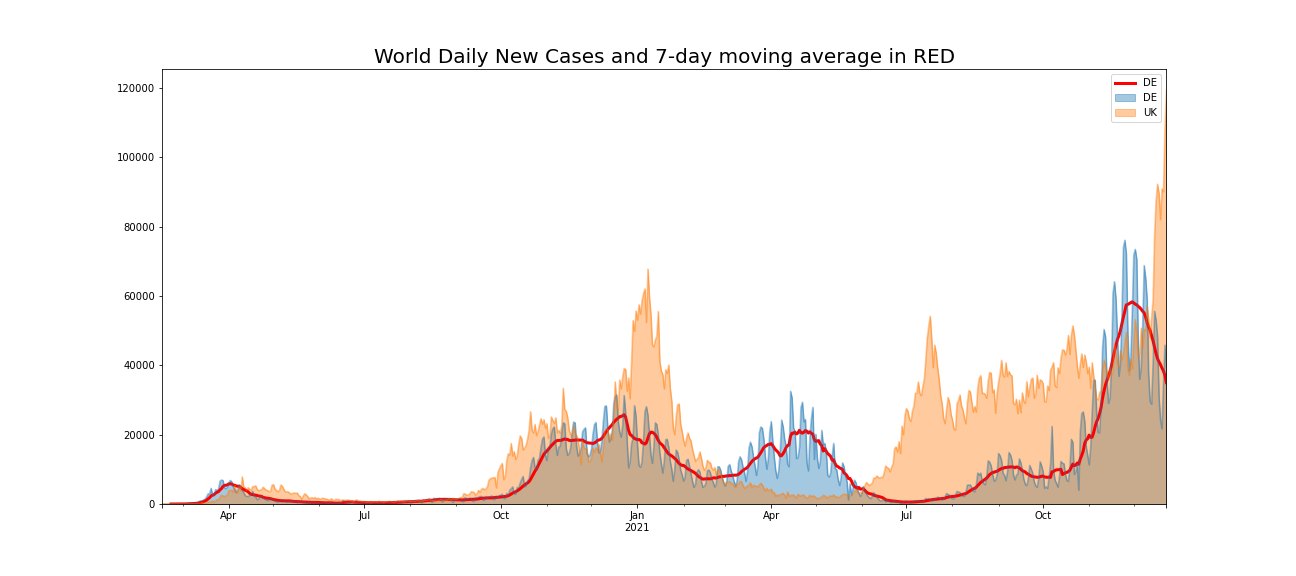

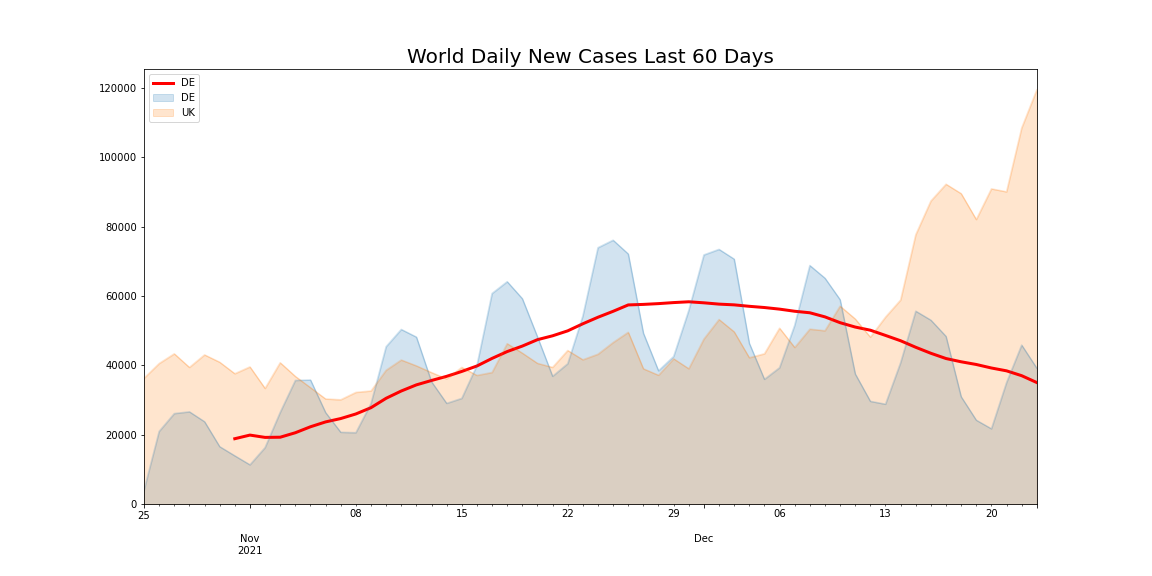

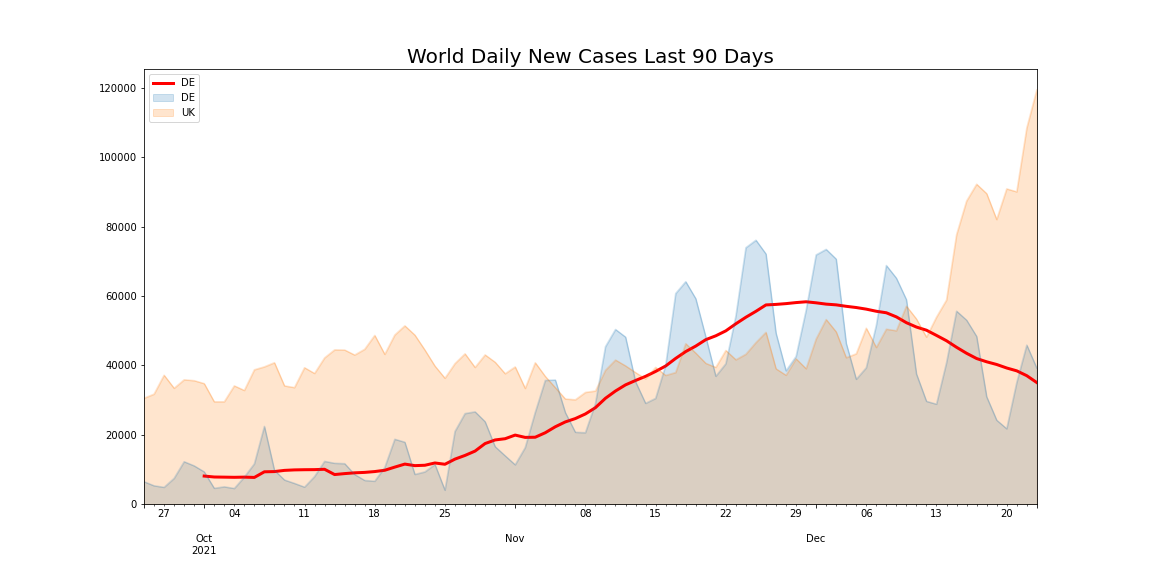

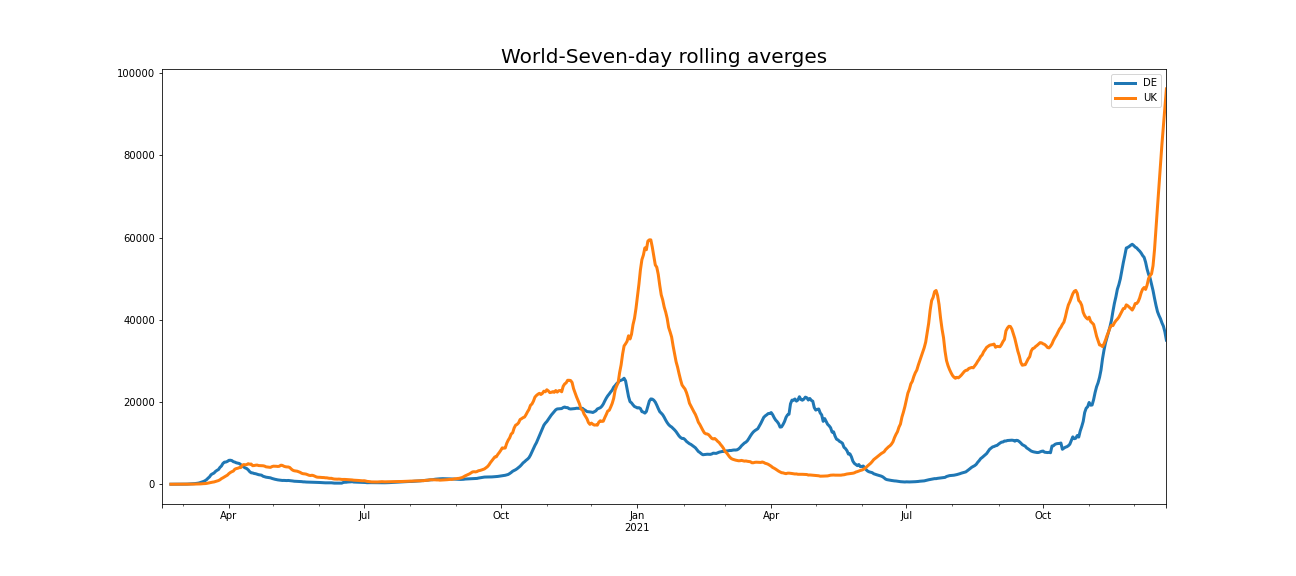

In [87]:
!ls covid_data_update/*.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

png_list

from IPython.display import Image

for file in png_list:    
    local = Image(file)
    local

### tabla rasa

In [88]:
# this cell will delete all files created in todays session
!rm -rf covid_data_update

In [89]:
# Ensure helper files used have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx
!rm -f flist_of_covid_png